In [45]:
import pandas as pd
import numpy as np
import duckdb
import re
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# import minmaxscaler
from sklearn.preprocessing import MinMaxScaler

In [46]:
con = duckdb.connect()
df = con.sql("""
    select
        lower(brand) as brand
        , lower(model) as model
        , replace(replace(replace(lower(version), '[', ''), ']', ''), ', ', ' ') as version
        -- , replace(replace(description, '[', ''), ']', '') as description
        , kms
        , lower(energy) as energy
        , lower(gear) as gear
        , year registry_year
        , price
        , dateIntegration
    from read_parquet('db.parquet')
    order by dateIntegration;  
""").fetchdf()

In [47]:
df

,brand,model,version,kms,energy,gear,registry_year,price,dateIntegration
0,volkswagen,t-roc,t-roc 2.0 tdi 150 start/stop dsg7 r-line,20400,diesel,automatique,2021,35990,2023-03-07
1,citroen,grand c4 picasso,1.2 puretech 130cv bvm6 7pl feel + sieges chau...,84300,essence,manuelle,2019,21310,2023-03-07
2,citroen,c4,bluehdi 110 s&s bvm6 live,2400,diesel,manuelle,2021,20500,2023-03-07
3,citroen,c1,c1 vti 72 s&s feel,5000,essence,manuelle,2021,12890,2023-03-07
4,citroen,c3,1.2 puretech 83ch s&s shine 123g,100,essence,manuelle,2021,17490,2023-03-07
...,...,...,...,...,...,...,...,...,...
3981099,volkswagen,taigo,1.0 tsi 110ch r-line,10,essence,automatique,2023,29970,2023-04-16
3981100,volkswagen,polo,1.2 tdi 75,113000,diesel,manuelle,2011,7990,2023-04-16
3981101,renault,zoe,(2) r110 zen,24300,électrique,automatique,2020,15290,2023-04-16
3981102,volkswagen,polo,v 1.4 tdi 90 bluemotion technology serie speci...,151452,diesel,manuelle,2015,8990,2023-04-16


In [48]:
df = df[(df.brand == 'peugeot')]

def clean_version(x):
    stopword = ['cv', ' ', '', '5p', '-', '.', '|', '+', '+options', 'options', 'option', 'opt', 'brand', 'model', 'energy', 'gear', 'kms', 'version', 's&s']
    version = x.lower().split(' ')
    version = [word.replace('cv', '').replace('.', '') for word in version if word not in stopword]
    for v in version:
        if re.search(r'\d', v):
            version[version.index(v)] = v.replace('ch', '')
    return ' '.join(version)

df.version = df.version.apply(clean_version)
# df.description = df.description.apply(clean_version)
# df.description = df.description.apply(lambda x: ' '.join(x.split(',')[5:15]))
df.brand = df.brand.apply(lambda x: x.lower())
df.model = df.model.apply(lambda x: x.lower())
df.dateIntegration = df.dateIntegration.apply(lambda x: x.strftime('%Y-%m-%d'))
df['title'] = df.brand + ' ' + df.model + ' ' + df.version + ' ' + df.energy + ' ' + df.gear + ' ' + df.dateIntegration
df = df.drop(columns=['brand', 'model', 'version', 'energy', 'gear', 'dateIntegration'])
df.title = df.title.apply(lambda x: ' '.join(sorted(set(x.split(' ')))))
df.drop_duplicates(subset=['title', 'kms', 'registry_year'], inplace=True)
df.shape

/var/folders/7q/70b15dsj6pqctqjjb94l8qw80000gp/T/ipykernel_70515/3432120116.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.version = df.version.apply(clean_version)
/var/folders/7q/70b15dsj6pqctqjjb94l8qw80000gp/T/ipykernel_70515/3432120116.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.brand = df.brand.apply(lambda x: x.lower())
/var/folders/7q/70b15dsj6pqctqjjb94l8qw80000gp/T/ipykernel_70515/3432120116.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

(633800, 4)

In [49]:
df

,kms,registry_year,price,title
492,34117,2018,10990,2023-03-07 active automatique electrique ion p...
737,32450,2020,23900,136 2023-03-07 208 50 active automatique busin...
782,75791,2017,12790,12 2023-03-07 208 82 bvm5 essence manuelle peu...
1144,73863,2019,12990,100 2023-03-07 208 active bluehdi business bvm...
1392,46327,2018,10000,10 108 2023-03-07 3p camera essence manuelle p...
...,...,...,...,...
3974901,371000,2005,4490,20 2023-04-16 407 confort diesel fap hdi126 ma...
3975362,148700,1988,1350,10 2023-04-16 205 essence junior manuelle peugeot
3977549,211983,2010,4999,110 16 2023-04-16 308 bvm6 diesel fap feline h...
3978726,15530,2021,35900,180 2023-04-16 3008 automatique eat8 essence g...


In [50]:
df1 = df.copy()

In [51]:
vectorizer = CountVectorizer()
X_text = vectorizer.fit_transform(df1.title)
# X_desc = vectorizer.fit_transform(df.description)
# X_text = np.concatenate((X_text.toarray(), X_desc.toarray()), axis=1)
# Sélectionner les colonnes numériques
X_num = df1.drop(columns=['title', 'price']).values
# sc = StandardScaler()
sc = MinMaxScaler()
X = sc.fit_transform(X_num)
# Concaténer les deux matrices
X = np.concatenate((X_text.toarray(), X_num), axis=1)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, df.price, test_size=0.2, random_state=42)

In [55]:
# XGBoost
# Best parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
xgb = XGBRegressor(colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=1000)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print('XGBoost')
print('R2: ', r2_score(y_test, y_pred))
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))

KeyboardInterrupt: 

In [ ]:
df['prediction'] = xgb.predict(X)
df.prediction = df.prediction.apply(lambda x: round(x, -2))
df['error'] = df.price - df.prediction
df['error_percent'] = df.error / df.price * 100

In [31]:
df

,kms,registry_year,price,title,prediction,error,error_percent
1562,24868,2019,15000,10 117 2018 2023-03-07 dig-t essence manuelle ...,15200.0,-200.0,-1.333333
5873,10000,2021,15900,10 20215 2023-03-07 92 enigma essence ig-t man...,17000.0,-1100.0,-6.918239
7150,27450,2019,15990,10 100 2023-03-07 automatique essence euro6-ev...,16400.0,-410.0,-2.564103
7973,6000,2022,47450,190 2023-03-07 automatique ch e-power hybride ...,44800.0,2650.0,5.584826
8868,53165,2017,18990,115 12 2023-03-07 dig-t essence manuelle n-con...,17900.0,1090.0,5.739863
...,...,...,...,...,...,...,...
3962359,100135,2019,11900,10 100 2023-04-16 automatique essence ig-t mic...,13100.0,-1200.0,-10.084034
3965113,77997,2016,15990,16e 190 2023-04-16 4x4-i 7 a all-mode automati...,15700.0,290.0,1.813634
3969491,34518,2019,26490,150 2023-04-16 7 dci diesel euro6d-t manuelle ...,26000.0,490.0,1.849755
3971245,21401,2021,17990,10 2021 2023-04-16 92 automatique essence fran...,16600.0,1390.0,7.726515


In [32]:
from matplotlib import pyplot as plt
import seaborn as sns

/var/folders/7q/70b15dsj6pqctqjjb94l8qw80000gp/T/ipykernel_70515/549451625.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.error, bins=100)


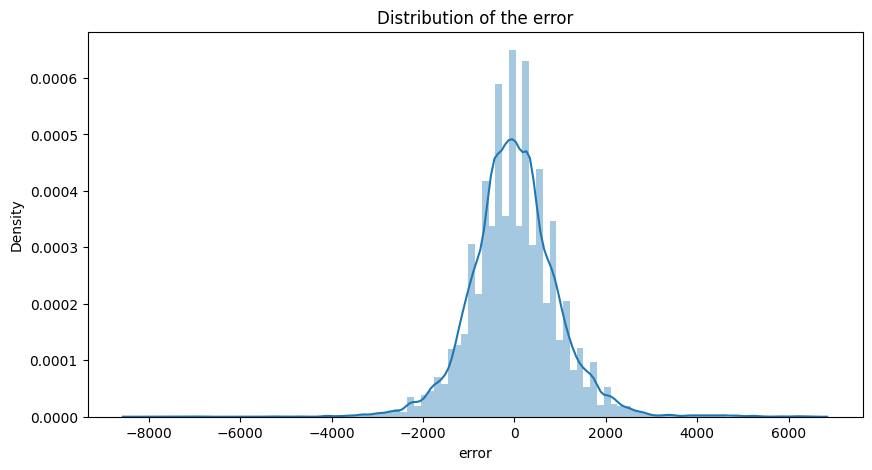

In [33]:
# Bar plot repartition error abs
plt.figure(figsize=(10, 5))
sns.distplot(df.error, bins=100)
plt.title('Distribution of the error')
plt.show()

In [34]:
df.error.describe()

count    88091.000000
mean        -0.242295
std        955.115724
min      -8276.000000
25%       -520.000000
50%        -10.000000
75%        490.000000
max       6551.000000
Name: error, dtype: float64

In [35]:
df['error_abs'] = df.error.apply(lambda x: abs(x))


In [36]:
df[df.error_abs <2000].error_abs.describe()

count    84358.000000
mean       618.410690
std        464.209634
min          0.000000
25%        250.000000
50%        510.000000
75%        900.000000
max       1999.000000
Name: error_abs, dtype: float64

/var/folders/7q/70b15dsj6pqctqjjb94l8qw80000gp/T/ipykernel_70515/602821130.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.error_abs, bins=100)


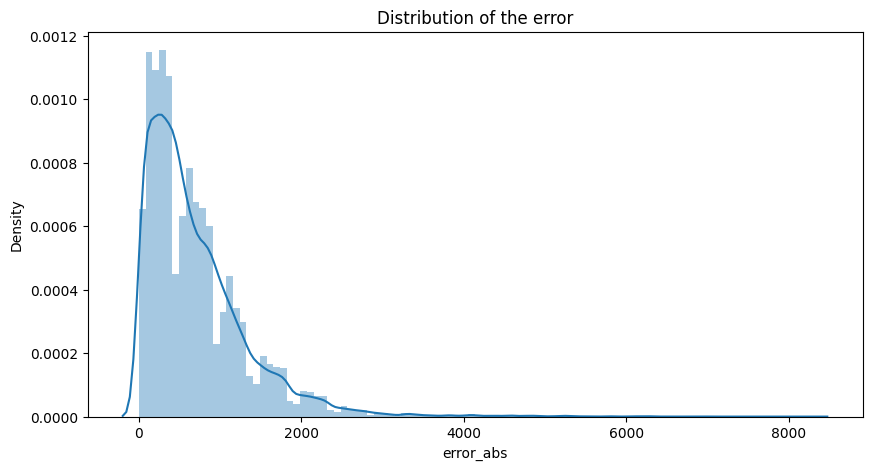

In [37]:
# Bar plot repartition error abs
plt.figure(figsize=(10, 5))
sns.distplot(df.error_abs, bins=100)
plt.title('Distribution of the error')
plt.show()

In [41]:
# test to predict price
car = {
    'brand': 'Nissan',
    'model': 'Qashqai',
    'version': '1.7 dci 130 tekna diesel manuelle',
    'dateIntegration': '2023-04-16',
    'kms': 60000,
    'registry_year': 2017,
}

def predict_price(car):
    car = pd.DataFrame(car, index=[0])
    car.version = car.version.apply(clean_version)
    car.brand = car.brand.apply(lambda x: x.lower())
    car.model = car.model.apply(lambda x: x.lower())
    car['title'] = car.brand + ' ' + car.model + ' ' + car.version + ' ' + car.dateIntegration
    car = car.drop(columns=['brand', 'model', 'version', 'dateIntegration'])
    car.title = car.title.apply(lambda x: ' '.join(sorted(set(x.split(' ')))))
    X_text = vectorizer.transform(car.title)
    X_num = car.drop(columns=['title']).values
    sc = StandardScaler()
    X = sc.fit_transform(X_num)
    X = np.concatenate((X_text.toarray(), X_num), axis=1)
    return xgb.predict(X)

print("r2_score : ", r2_score(y_test, y_pred))
print('RMSE : ', np.sqrt(mean_squared_error(y_test, y_pred)))
print(predict_price(car))
df[df.title.str.contains('qashqai') & (df.registry_year == 2017) & (df.kms < 80000) & df.title.str.contains('tekna') & df.title.str.contains('130') & df.title.str.contains('2023-04-16')]


r2_score :  0.9847026174755065
RMSE :  967.3816833925567
[19125.77]


,kms,registry_year,price,title,prediction,error,error_percent,error_abs
3910463,51025,2017,19499,130 16 2023-04-16 av/ar chauf dci diesel manue...,19200.0,299.0,1.533412,299.0


In [42]:
df[df.title.str.contains('qashqai') & (df.registry_year == 2017) & (df.kms < 80000) & df.title.str.contains('tekna') & df.title.str.contains('130') & df.title.str.contains('2023-04-16')].values

array([[51025, 2017, 19499,
        '130 16 2023-04-16 av/ar chauf dci diesel manuelle nissan qashqai radar siege tekna tpano',
        19200.0, 299.0, 1.5334119698446074, 299.0]], dtype=object)

In [43]:
# Export the model to a pickle file
import pickle
pickle.dump(xgb, open('model.pkl', 'wb'))
pickle.dump(vectorizer, open('vectorizer.pkl', 'wb'))
pickle.dump(sc, open('scaler.pkl', 'wb'))

In [40]:
# Load the model from the file
pkl_model = pickle.load(open('model.pkl', 'rb'))
plk_vectorizer = pickle.load(open('vectorizer.pkl', 'rb'))
plk_sc = pickle.load(open('scaler.pkl', 'rb'))

# Use the loaded model to make predictions
print("r2_score : ", r2_score(y_test, y_pred))
print('RMSE : ', np.sqrt(mean_squared_error(y_test, y_pred)))
car = {
    'brand': 'Nissan',
    'model': 'Qashqai',
    'version': '1.7 dci 130 tekna',
    'kms': 60000,
    'registry_year': 2017,
}
def predict_price_with_model(car):
    car = pd.DataFrame(car, index=[0])
    car.version = car.version.apply(clean_version)
    car.brand = car.brand.apply(lambda x: x.lower())
    car.model = car.model.apply(lambda x: x.lower())
    car['title'] = car.brand + ' ' + car.model + ' ' + car.version
    car = car.drop(columns=['brand', 'model', 'version'])
    car.title = car.title.apply(lambda x: ' '.join(sorted(set(x.split(' ')))))
    X_text = plk_vectorizer.transform(car.title)
    X_num = car.drop(columns=['title']).values
    X = plk_sc.fit_transform(X_num)
    X = np.concatenate((X_text.toarray(), X_num), axis=1)
    return pkl_model.predict(X)

print(predict_price_with_model(car))
df[df.title.str.contains('nissan|qashqai')]


r2_score :  0.9847026174755065
RMSE :  967.3816833925567
[20632.133]


,kms,registry_year,price,title,prediction,error,error_percent,error_abs
1562,24868,2019,15000,10 117 2018 2023-03-07 dig-t essence manuelle ...,15200.0,-200.0,-1.333333,200.0
5873,10000,2021,15900,10 20215 2023-03-07 92 enigma essence ig-t man...,17000.0,-1100.0,-6.918239,1100.0
7150,27450,2019,15990,10 100 2023-03-07 automatique essence euro6-ev...,16400.0,-410.0,-2.564103,410.0
7973,6000,2022,47450,190 2023-03-07 automatique ch e-power hybride ...,44800.0,2650.0,5.584826,2650.0
8868,53165,2017,18990,115 12 2023-03-07 dig-t essence manuelle n-con...,17900.0,1090.0,5.739863,1090.0
...,...,...,...,...,...,...,...,...
3962359,100135,2019,11900,10 100 2023-04-16 automatique essence ig-t mic...,13100.0,-1200.0,-10.084034,1200.0
3965113,77997,2016,15990,16e 190 2023-04-16 4x4-i 7 a all-mode automati...,15700.0,290.0,1.813634,290.0
3969491,34518,2019,26490,150 2023-04-16 7 dci diesel euro6d-t manuelle ...,26000.0,490.0,1.849755,490.0
3971245,21401,2021,17990,10 2021 2023-04-16 92 automatique essence fran...,16600.0,1390.0,7.726515,1390.0
